## Cortical Activity of Evaluation
This notebook compares averaging cortical activity of evaluation dataset (one prediction for all subjects) vs individual cortical data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.run_model as rm
import matplotlib.pyplot as plt

In [2]:
def heatmap_annotate(df_to_plot, ds_order, ax, ds_order_y=None, column=['train_dataset'], row=['eval_dataset'], value=['R_eval'], cmap='inferno', vmin=0, vmax=0.5):
    if ds_order_y is None:
        if 'Fusion' in ds_order:
            ds_order_y = [ds for ds in ds_order if ds!='Fusion']
        else:
            ds_order_y = ds_order
    V = pd.pivot_table(df_to_plot, columns=column, index=row, values=value)
    V = V.reindex(ds_order_y, axis=0)
    V = V.reindex(ds_order, level=1, axis=1)

    sns.heatmap(V.values, annot=True, fmt=".2f", cmap=cmap, vmin=vmin, vmax=vmax, 
                xticklabels=V.columns.get_level_values(1).values, 
                yticklabels=V.index.values, square=True, ax=ax)
    if 'Fusion' in ds_order:
        ax.axvline(len(ds_order_y), color='k', linewidth=2)

    return ax

### Loading avg and loo models

In [3]:
method = 'L2reg'
train_ds_list = ["MDTB", "Language", "Social", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]#, "Fusion"]
eval_ds_list = ["MDTB", "Language", "Social", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC", "HCPur100"]
eval_names = ["MDTB", "Languagelocalizer", "Socialsocial", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC", "HCPur100"]
df_all = pd.DataFrame()
for d, dataset_name in enumerate(train_ds_list):

    # Load avg performances
    df = rm.comb_eval(models=[dataset_name+"-avg-Cavg"],methods=[method],eval_data=eval_names,cerebellum='MNISymC3')
    df_all = pd.concat([df_all, df], ignore_index=True)

    df = rm.comb_eval(models=[dataset_name+"-avg-Cind"],methods=[method],eval_data=eval_names,cerebellum='MNISymC3')
    df_all = pd.concat([df_all, df], ignore_index=True)

    # Load loo performances
    df = rm.comb_eval(models=[dataset_name+"-loo-Cavg"],methods=[method],eval_data=[eval_names[d]],cerebellum='MNISymC3')
    df_all = pd.concat([df_all, df], ignore_index=True)

    df = rm.comb_eval(models=[dataset_name+"-loo-Cind"],methods=[method],eval_data=[eval_names[d]],cerebellum='MNISymC3')
    df_all = pd.concat([df_all, df], ignore_index=True)

df_cortical_avg = df_all[df_all.cortical_act == 'avg'].reset_index(drop=True)
df_cortical_ind = df_all[df_all.cortical_act == 'ind'].reset_index(drop=True)

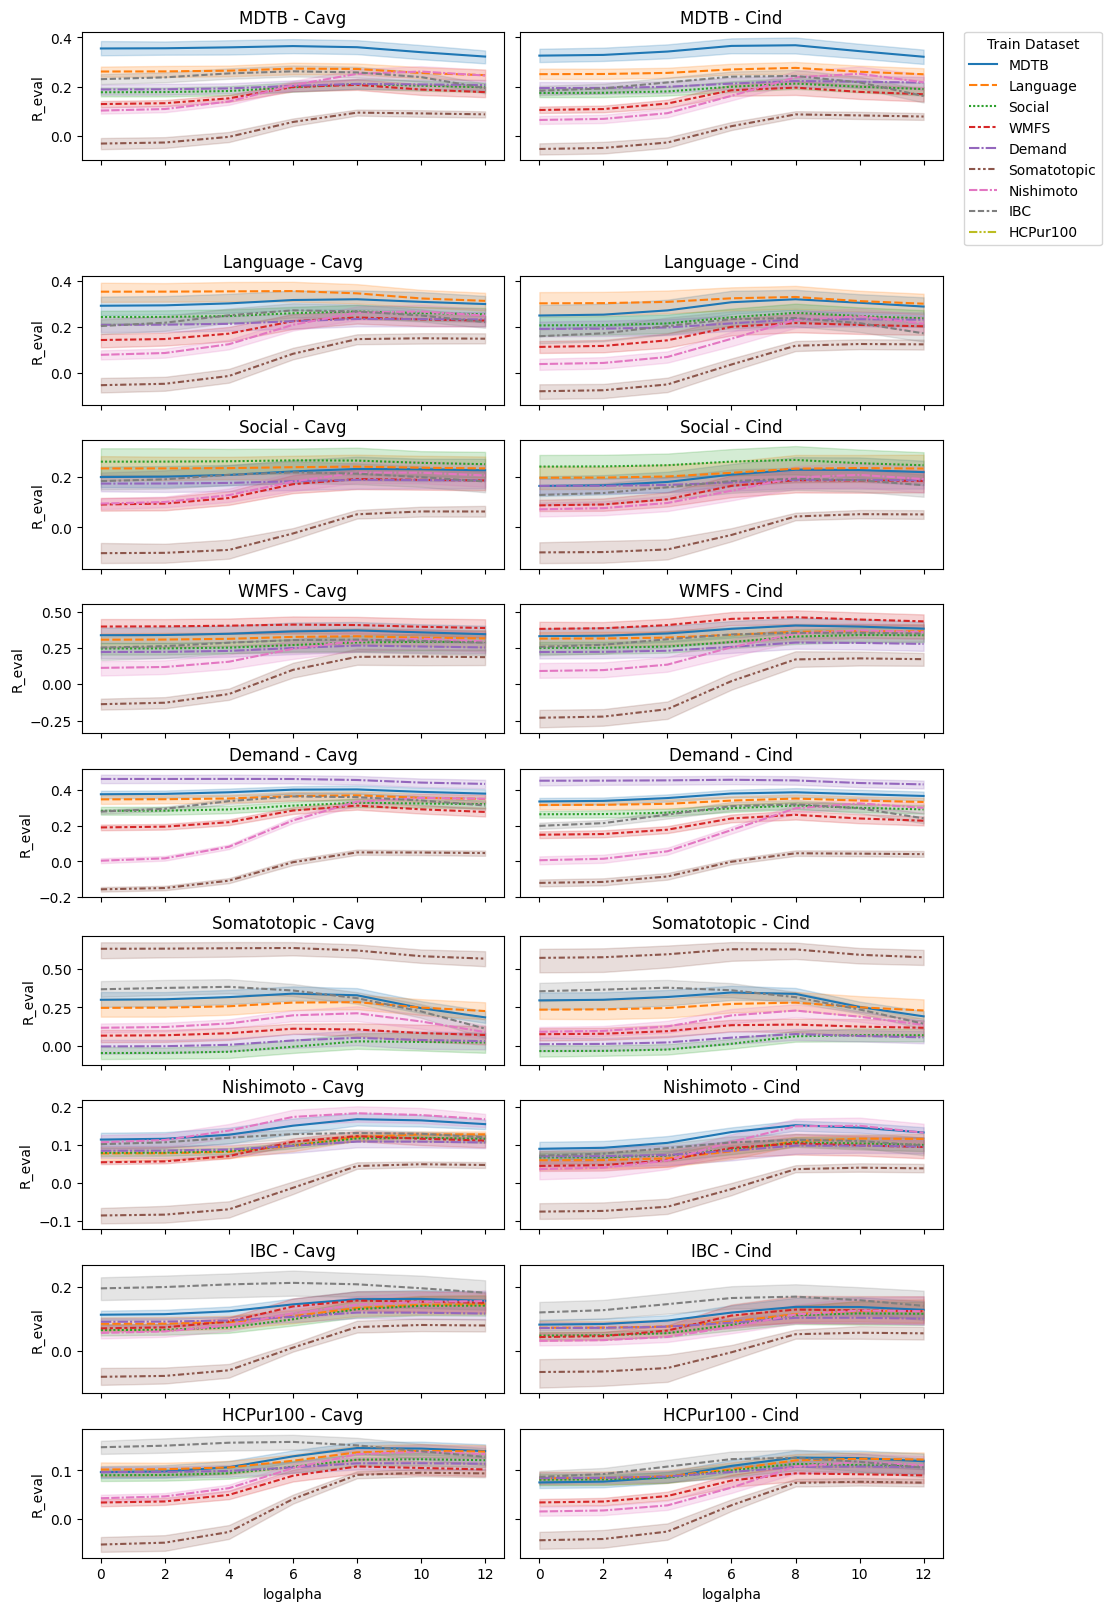

In [4]:
fig, axes = plt.subplots(len(eval_ds_list), 2, figsize=(11, 16), sharey='row', sharex='col', constrained_layout=True)
for i,ed in enumerate(eval_ds_list):
    # Left subplot
    ax_cavg = axes[i, 0]
    df_to_plot = df_cortical_avg[(df_cortical_avg.eval_dataset==ed) & ((df_cortical_avg.train_dataset!=ed)
                                                                       | (df_cortical_avg.model.str.contains('loo')))]
    sns.lineplot(data=df_to_plot, y='R_eval', x='logalpha', hue='train_dataset', style='train_dataset',
                     hue_order=eval_ds_list, style_order=eval_ds_list, legend=False, ax=ax_cavg)
    ax_cavg.set_title(f'{ed} - Cavg')

    # Right subplot
    ax_cind = axes[i, 1]
    df_to_plot = df_cortical_ind[(df_cortical_ind.eval_dataset==ed) & ((df_cortical_ind.train_dataset!=ed)
                                                                       | (df_cortical_ind.model.str.contains('loo')))]
    sns.lineplot(data=df_to_plot, y='R_eval', x='logalpha', hue='train_dataset', style='train_dataset',
                     hue_order=eval_ds_list, style_order=eval_ds_list, ax=ax_cind)
    ax_cind.set_title(f'{ed} - Cind')

    if i == 0:
        ax_cind.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Train Dataset')
    else:
        ax_cind.legend_.remove()

### Find best hyperparameter

In [5]:
# cortical avg
A = pd.pivot_table(df_cortical_avg, index=['train_dataset'],columns=['logalpha'],values=['R_eval'],aggfunc='mean').reindex(train_ds_list)
display(A)
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a = np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
display(bestla)
df_cortical_avg['isbest'] = df_cortical_avg.logalpha.values == bestla.loc[df_cortical_avg.train_dataset].values.flatten()

R_eval                                                    \
logalpha           0.0       2.0       4.0       6.0       8.0       10.0   
train_dataset                                                               
MDTB           0.242059  0.243714  0.251905  0.268562  0.275797  0.264579   
Language       0.227867  0.228446  0.232004  0.243487  0.250907  0.243181   
Social         0.176748  0.177458  0.181965  0.197975  0.212701  0.210448   
WMFS           0.126727  0.129847  0.147843  0.193565  0.209886  0.199124   
Demand         0.203104  0.203571  0.206376  0.215153  0.222037  0.217741   
Somatotopic   -0.057426 -0.052702 -0.025126  0.056334  0.111633  0.113077   
Nishimoto      0.063603  0.070555  0.103743  0.178124  0.227646  0.233846   
IBC            0.212073  0.220539  0.240526  0.251236  0.245064  0.227647   

                         
logalpha           12.0  
train_dataset            
MDTB           0.253607  
Language       0.237936  
Social         0.207112  
WMFS           0.191922  
Demand         0.214275  
Somatotopic    0.110279  
Nishimoto      0.222202  
IBC            0.202267

,best_logalpha
train_dataset,
MDTB,8.0
Language,8.0
Social,8.0
WMFS,8.0
Demand,8.0
Somatotopic,10.0
Nishimoto,10.0
IBC,6.0


In [6]:
# cortical ind
A = pd.pivot_table(df_cortical_ind, index=['train_dataset'],columns=['logalpha'],values=['R_eval'],aggfunc='mean').reindex(train_ds_list)
display(A)
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a = np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
display(bestla)
df_cortical_ind['isbest'] = df_cortical_ind.logalpha.values == bestla.loc[df_cortical_ind.train_dataset].values.flatten()

R_eval                                                    \
logalpha           0.0       2.0       4.0       6.0       8.0       10.0   
train_dataset                                                               
MDTB           0.213866  0.216594  0.229984  0.256676  0.269342  0.258246   
Language       0.205820  0.206592  0.211387  0.227730  0.242238  0.237594   
Social         0.164245  0.165178  0.171129  0.192508  0.210613  0.204525   
WMFS           0.109874  0.113143  0.132066  0.179712  0.195542  0.185902   
Demand         0.194974  0.195602  0.199377  0.211466  0.222299  0.218669   
Somatotopic   -0.061853 -0.058080 -0.035912  0.038738  0.099093  0.100038   
Nishimoto      0.039425  0.044071  0.067995  0.138336  0.208858  0.221979   
IBC            0.158759  0.168709  0.195739  0.220963  0.225096  0.208675   

                         
logalpha           12.0  
train_dataset            
MDTB           0.244680  
Language       0.232186  
Social         0.198707  
WMFS           0.179298  
Demand         0.214810  
Somatotopic    0.096946  
Nishimoto      0.202358  
IBC            0.175724

,best_logalpha
train_dataset,
MDTB,8.0
Language,8.0
Social,8.0
WMFS,8.0
Demand,8.0
Somatotopic,10.0
Nishimoto,10.0
IBC,8.0


In [7]:
# Create a subset for best logalpha values
df_avg_best = df_cortical_avg[df_cortical_avg.isbest]
df_ind_best = df_cortical_ind[df_cortical_ind.isbest]

### Evaluation Heatmap at best Hyperparameter

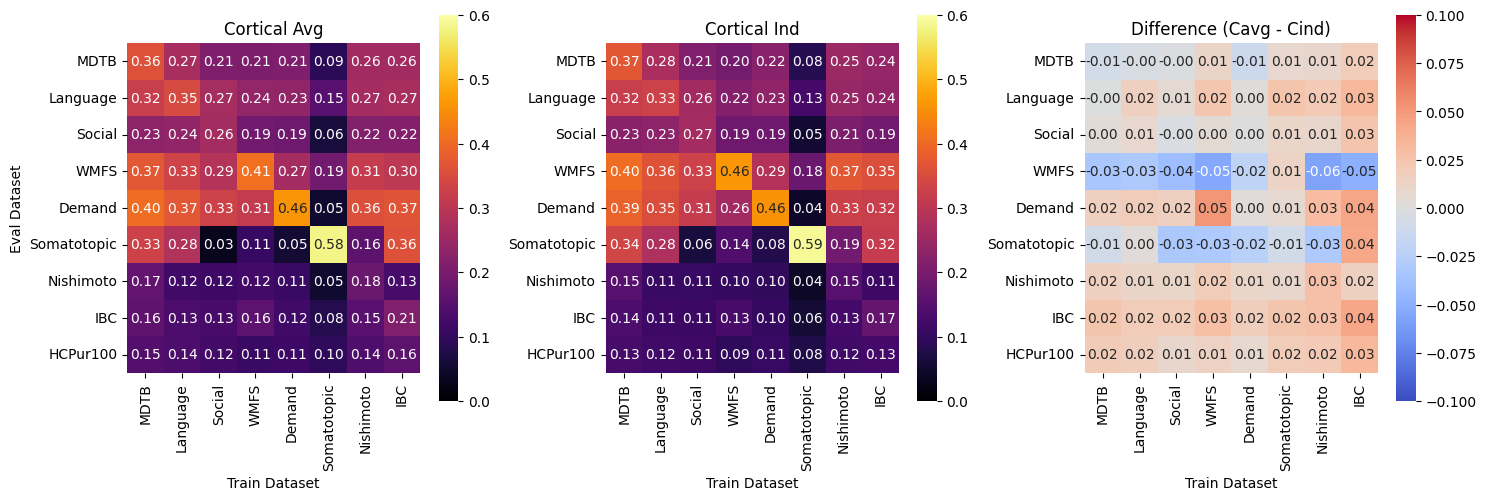

In [8]:
fig, axes = plt.subplots(1,3,figsize=(15,5))

# cortical avg
ax = heatmap_annotate(df_avg_best, ds_order=train_ds_list, ds_order_y=eval_ds_list, ax=axes[0], value=['R_eval'],
                      cmap='inferno', vmin=0, vmax=0.6)
ax.set_title('Cortical Avg')
ax.set_xlabel('Train Dataset')
ax.set_ylabel('Eval Dataset')

# cortical ind
ax = heatmap_annotate(df_ind_best, ds_order=train_ds_list, ds_order_y=eval_ds_list, ax=axes[1], value=['R_eval'],
                      cmap='inferno', vmin=0, vmax=0.6)
ax.set_title('Cortical Ind')
ax.set_xlabel('Train Dataset')

# Calculate the difference in 'R_eval' for the same group of (train_dataset, eval_dataset, eval_subj)
df_diff = pd.merge(df_avg_best[['train_dataset', 'eval_dataset', 'eval_subj', 'R_eval']],
                   df_ind_best[['train_dataset', 'eval_dataset', 'eval_subj', 'R_eval']],
                   on=['train_dataset', 'eval_dataset', 'eval_subj'],
                   suffixes=('_Cavg', '_Cind'))

df_diff['R_eval_diff'] = df_diff['R_eval_Cavg'] - df_diff['R_eval_Cind']
ax = heatmap_annotate(df_diff, ds_order=train_ds_list, ds_order_y=eval_ds_list, ax=axes[2], value=['R_eval_diff'],
                      cmap='coolwarm', vmin=-0.1, vmax=0.1)
ax.set_title('Difference (Cavg - Cind)')
ax.set_xlabel('Train Dataset')

plt.tight_layout()